# Dog Breed Classification Using Deep Learning in AWS Sagemaker

## Introduction
The goal of this project is to demonstrate how we can use a pretrained image classification model to classify the dog breed given an image of the dog. This is done by loading the pretrained model then using transfer learning we adapt the model to the dog breed classification dataset.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 86.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.25.76 requires botocore==1.27.75, but you have botocore 1.27.80 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.27.80 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [1]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt
# Hyper parameter tuning
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

- The Dataset Contains images of dogs of different breeds.
- There are 133 classes of dog breeds available.
- The Dataset is split into three directories train, validation and testing.
- Each Directory has 133 sub directories, one directory per dog breed class.

### Fetch the Dataset

In [5]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-09-24 11:11:41--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.32
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

100%[====================================>] 1,132,023,110 21.6MB/s   in 35s    

2022-09-24 11:12:16 (31.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

### Upload the Dataset to S3

In [3]:
# Upload metadata
sagemaker_session = sagemaker.Session()
BUCKET = sagemaker_session.default_bucket()
PREFIX = 'Project/dog-breed-dataset'
# ---
DATASET_LOCAL_DIR = "dogImages"

In [8]:
dataset_dir_path = sagemaker_session.upload_data(
    path=DATASET_LOCAL_DIR,
    bucket=BUCKET,
    key_prefix=PREFIX
)

print(f"Dataset directory path on S3 : {dataset_dir_path}")

Dataset directory path on S3 : s3://sagemaker-us-east-1-366839086443/Project/dog-breed-dataset


### Dataset Exploration

# train  # valid  # test
Dog Breed                                                
001.Affenpinscher                     64        8       8
002.Afghan_hound                      58        7       8
003.Airedale_terrier                  53        7       6
004.Akita                             63        8       8
005.Alaskan_malamute                  77        9      10
...                                  ...      ...     ...
129.Tibetan_mastiff                   48        6       6
130.Welsh_springer_spaniel            44        6       5
131.Wirehaired_pointing_griffon       30        4       3
132.Xoloitzcuintli                    26        4       3
133.Yorkshire_terrier                 30        4       4

[133 rows x 3 columns]


--- Distribution ---

          # train     # valid      # test
count  133.000000  133.000000  133.000000
mean    50.240602    6.278195    6.285714
std     11.880179    1.350384    1.712571
min     26.000000    4.000000    3.000000
25%     42.000000    6.000000    5.000000
50%     50.000000    6.000000    6.000000
75%     61.000000    7.000000    8.000000
max     77.000000    9.000000   10.000000

 --- Split distribution ---


array([[<AxesSubplot:title={'center':'# train'}>,
        <AxesSubplot:title={'center':'# valid'}>],
       [<AxesSubplot:title={'center':'# test'}>, <AxesSubplot:>]],
      dtype=object)

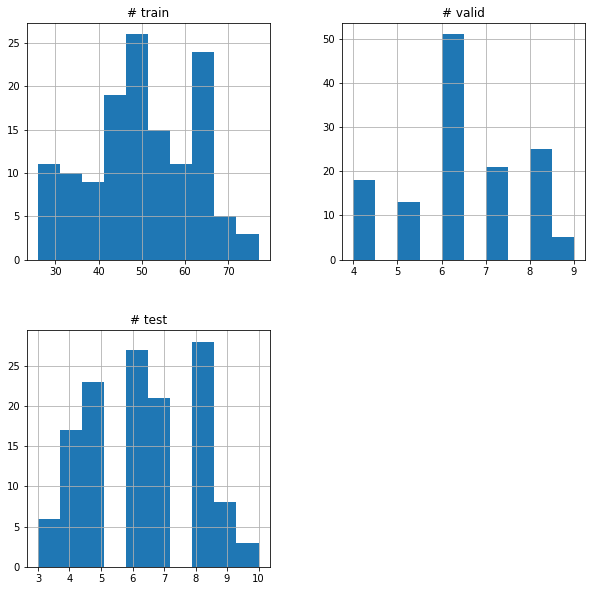

In [83]:
# Number of images for each class & their splits
classes = sorted(os.listdir(os.path.join(DATASET_LOCAL_DIR, 'train')))
num_train_images = []
num_valid_images = []
num_test_images = []

for _class in classes:
    num_train_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'train', _class))]))
    num_valid_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'valid', _class))]))
    num_test_images.append(len([file for file in os.listdir(os.path.join(DATASET_LOCAL_DIR, 'test', _class))]))

df_stats = pd.DataFrame(
    {
        "Dog Breed" : list(classes),
        "# train" : num_train_images,
        "# valid" : num_valid_images,
        "# test"  : num_test_images
    }
)
df_stats = df_stats.set_index("Dog Breed")

display(df_stats)

print("\n--- Distribution ---\n")
print(df_stats.describe())

print("\n --- Split distribution ---")
display(df_stats.hist(figsize=(10, 10)))


 --- Class distribution ---


<AxesSubplot:xlabel='Dog Breed'>

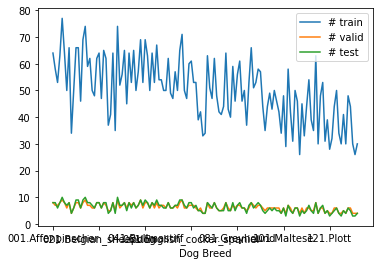

In [84]:
print("\n --- Class distribution ---")
df_stats.plot()

***From the above quick eda it is clear that:***
- not all classes have the same number of images for train, test & validation.
- Most of the classes have on average 50 train images, 6 validation images, and 6 test images.
- The dataset isn't completely imbalanced with respect to the # of images in each class.

***From a Quick manual exploration it is clear that:***
- Not all images have the same shape.
- Some images are too big.

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [2]:
# hardcoding data set directory path to avoid re-uploading the data
dataset_dir_path = 's3://sagemaker-us-east-1-366839086443/Project/dog-breed-dataset'
role = sagemaker.get_execution_role()

#### Tuned Hyperparameters
- **learning rate (lr)** : Learning rate usually takes small values on a log scale, the learning rate affects the speed of training and a suitable learning rate doesn't cause the learning process to diverge.
- **batch size** : The batch size affects the speed of training as well as the accuracy. As the batch size increases the outcome values become more stable. However, the training process might get longer.
- **epochs** : The more the model is trained, the better the results, but too much training might cause overfitting.

In [3]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": CategoricalParameter([1, 2])
}

In [4]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [5]:
#TODO: Create estimators for your HPs
cwd = os.getcwd()

estimator = PyTorch(
    entry_point=os.path.join(cwd, "scripts", "hpo.py"),
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c5.2xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=3,
    objective_type=objective_type,
)

In [6]:
# TODO: Fit your HP Tuner
tuner.fit({'data': dataset_dir_path}, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................................................................................................................................................................................................!


In [7]:
# TODO: Get the best estimators and the best HPs
tuner_job_name = 'pytorch-training-220926-1846'
tuner = sagemaker.tuner.HyperparameterTuner.attach(tuner_job_name)

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-09-26 19:02:36 Starting - Preparing the instances for training
2022-09-26 19:02:36 Downloading - Downloading input data
2022-09-26 19:02:36 Training - Training image download completed. Training in progress.
2022-09-26 19:02:36 Uploading - Uploading generated training model
2022-09-26 19:02:36 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'epochs': '"1"',
 'lr': '0.00528420377217063',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-09-26-18-46-20-169"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-366839086443/pytorch-training-2022-09-26-18-46-20-169/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

estimator = # TODO: Your estimator here

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()